In [ ]:
!pip install ultralytics

In [2]:
# For image processing
import os
import cv2
import json
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# For object detection
from ultralytics import YOLO
from ultralytics.data.converter import convert_coco
from ultralytics.data.annotator import auto_annotate
from ultralytics.data.converter import convert_segment_masks_to_yolo_seg

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Several utillities and helper functions

# Function to visualize image with bounding boxxes
def visualize_bboxxes(image_id = 574):
  # Get rows with image_id == image_id
  dummy = df[df["image_id"] == image_id].reset_index(drop = True)
  filename = dummy.iloc[0, 10]

  # Visualize image with bounding box example

  # Open and read image
  image = cv2.imread(filename)

  for i in range(len(dummy)):
    # Top left bounding box coordinate
    x1, y1 = int(dummy["bbox"][i][0]), int(dummy["bbox"][i][1])

    # Bottom right bounding box coordinate
    x2, y2 = x1 + int(dummy["bbox"][i][2]), y1 + int(dummy["bbox"][i][3])

    # Draw rectangle on image
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

  # Display the result
  plt.imshow(image)

# Function to visualize image with contours or masks
def visualize_contours(image_id = 574):
  dummy = df[df["image_id"] == image_id].reset_index(drop = True)
  image = cv2.imread(dummy.iloc[0, 10])

  for i in range(len(dummy)):
    points = dummy["segmentation"][i][0]
    contour = []
    for j in range(int(len(points)/2)):
      x = int(points[2*j])
      y = int(points[2*j+1])
      contour.append([x, y])
    contour = np.array(contour)
    cv2.drawContours(image, [contour], -1, (0, 255, 0), 3)

  plt.imshow(image)

# Function to convert from COCO to YOLO format
def convert_coco_to_yolo(image_id = 574):
  # Get instances of specific image id
  dummy = df[df["image_id"] == image_id].reset_index(drop = True)

  # Get filename
  filename = dummy["file_name"][0].split("/")[-1].replace("jpg", "txt")

  # Get width and height of image
  width = dummy.iloc[0, 8]
  height = dummy.iloc[0, 9]

  # Get category ids
  category_ids = np.array(dummy["category_id"])

  # Define points list
  points = []

  # Iterate over all segmentation masks
  for i in range(len(dummy)):
    # Get each masks
    point = np.array(dummy["segmentation"][i][0])

    # Reformat [[x1, y1], [x2, y2], ..., [xn, yn]]
    point = point.reshape(-1, 2)

    # Normalize using width and height
    point[:, 0] /= width
    point[:, 1] /= height

    # Reformat to [x1, y1, x2, y2, ..., xn, yn]
    point = point.reshape(1, -1)

    # Append to points
    points.append(point)

  # Write to YOLO format
  with open(filename, "w") as f:
      for class_id, point in zip(category_ids, points):
          normalized = []
          for i in range(int(len(point[0])/2)):
            x, y = float(point[0][2*i]), float(point[0][2*i+1])
            normalized.extend([x, y])
          line = f"{class_id} " + " ".join(f"{coord:.6f}" for coord in normalized)
          f.write(line + "\n")

In [ ]:
# Define important directories
train_dir = "/content/drive/MyDrive/CarDD_release/annotations/instances_train2017.json"
val_dir = "/content/drive/MyDrive/CarDD_release/annotations/instances_val2017.json"
test_dir = "/content/drive/MyDrive/CarDD_release/annotations/instances_test2017.json"
images_dir = "/content/drive/MyDrive/CarDD_release/CarDD_COCO/images/train"
masks_dir = "/content/drive/MyDrive/CarDD_release/CarDD_SOD/CarDD-TR/CarDD-TR-Mask"
output_dir = "/content/drive/MyDrive/CarDD_release/CarDD_SOD/CarDD-TR/CarDD-TR-Mask-YOLO"

In [ ]:
# # Convert from COCO format to YOLO
# convert_coco(labels_dir = labels_dir, use_segments = True)

In [ ]:
# # Try YOLO auto annotate tool
# auto_annotate(data = images_dir, det_model = "yolo11x.pt", sam_model = "sam_b.pt")

In [ ]:
# # Convert masks from COCO to YOLO format
# convert_segment_masks_to_yolo_seg(masks_dir = masks_dir, output_dir = output_dir, classes = 6)

# Convert Labels from COCO to YOLO Format

In [ ]:
# Load JSON
with open(train_dir, "r") as f:
    data = json.load(f)

In [ ]:
# Convert 'images' section to DataFrame
images_df = pd.DataFrame(data["images"])
annotations_df = pd.DataFrame(data["annotations"])
categories_df = pd.DataFrame(data["categories"])

# Rename filename to absolute path
images_df["file_name"] = images_dir + "/" + images_df["file_name"]

# Rename id columns
images_df = images_df.rename(columns = {"id":"image_id"})
categories_df = categories_df.rename(columns = {"id":"category_id"})

# Merge dataframes
annotations_df = pd.merge(annotations_df, images_df, on = "image_id")
df = pd.merge(annotations_df, categories_df, on = "category_id")

In [ ]:
# Get the amount of each classes
df["name"].value_counts()

name
scratch          2560
dent             1806
crack             651
lamp broken       494
glass shatter     475
tire flat         225
Name: count, dtype: int64

In [ ]:
# Get image with most amount of instances
df.groupby("image_id")["category_id"].count().sort_values(ascending = False)

image_id
574     13
1978    12
3411    12
1731    11
1801    11
        ..
30       1
32       1
3981     1
3980     1
3979     1
Name: category_id, Length: 2816, dtype: int64

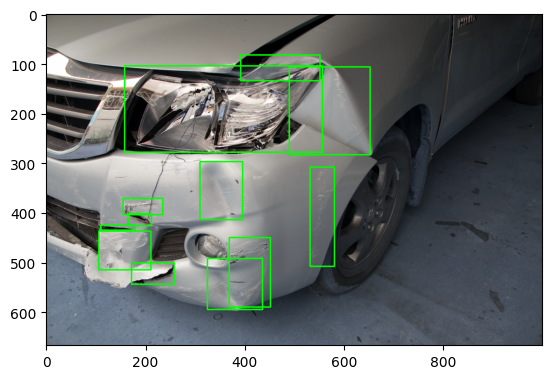

In [ ]:
# Visualize an image with its bounding boxxes as example
visualize_bboxxes(image_id = 1978)

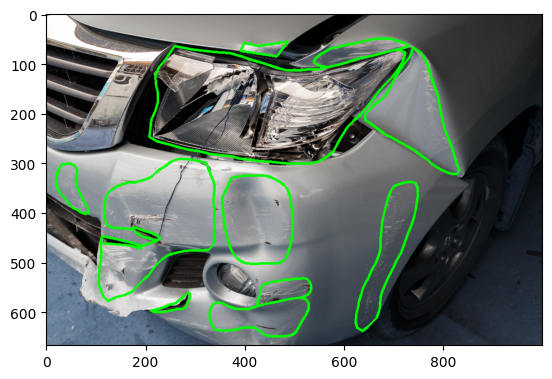

In [ ]:
# Visualize an image with its contours or masks as example
visualize_contours(574)

In [ ]:
# Choose directory to save annoatations
output_dir = "/content/drive/MyDrive/CarDD_release/CarDD_COCO/labels/train"
os.chdir(output_dir)

# Convert all images from COCO format to YOLO format
image_ids = df["image_id"].unique().tolist()
for image_id in image_ids:
  convert_coco_to_yolo(image_id = image_id)

# Go back to main directory
os.chdir("/content")

# Convert Masks from COCO to YOLO Format

In [ ]:
# Get absolute path of every masks
masks = os.listdir(masks_dir)
for i in range(len(masks)):
  masks[i] = os.path.join(masks_dir, masks[i])

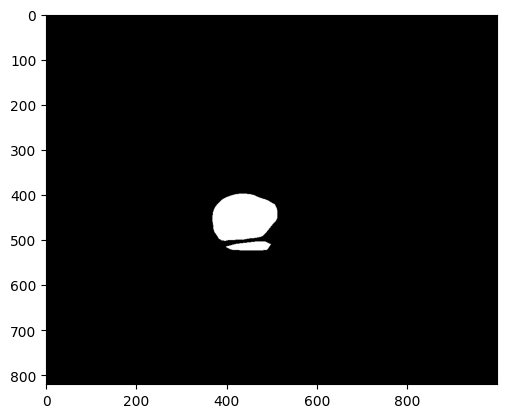

In [ ]:
# Show mask example from masks
binary_mask = cv2.imread(masks[0])
plt.imshow(binary_mask)

In [ ]:
# Convert mask from 3-channel to single channel (gray-scale)
gray_mask = cv2.cvtColor(binary_mask, cv2.COLOR_BGR2GRAY)
contours, _ = cv2.findContours(gray_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get largest contour
c = max(contours, key = cv2.contourArea)
(x, y, w, h) = cv2.boundingRect(c)
print("Number of Points:", len(c))

# Use approx Poly DP
peri = cv2.arcLength(c, True)
approx = cv2.approxPolyDP(c, 0.001 * peri, True)

Number of Points: 158


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
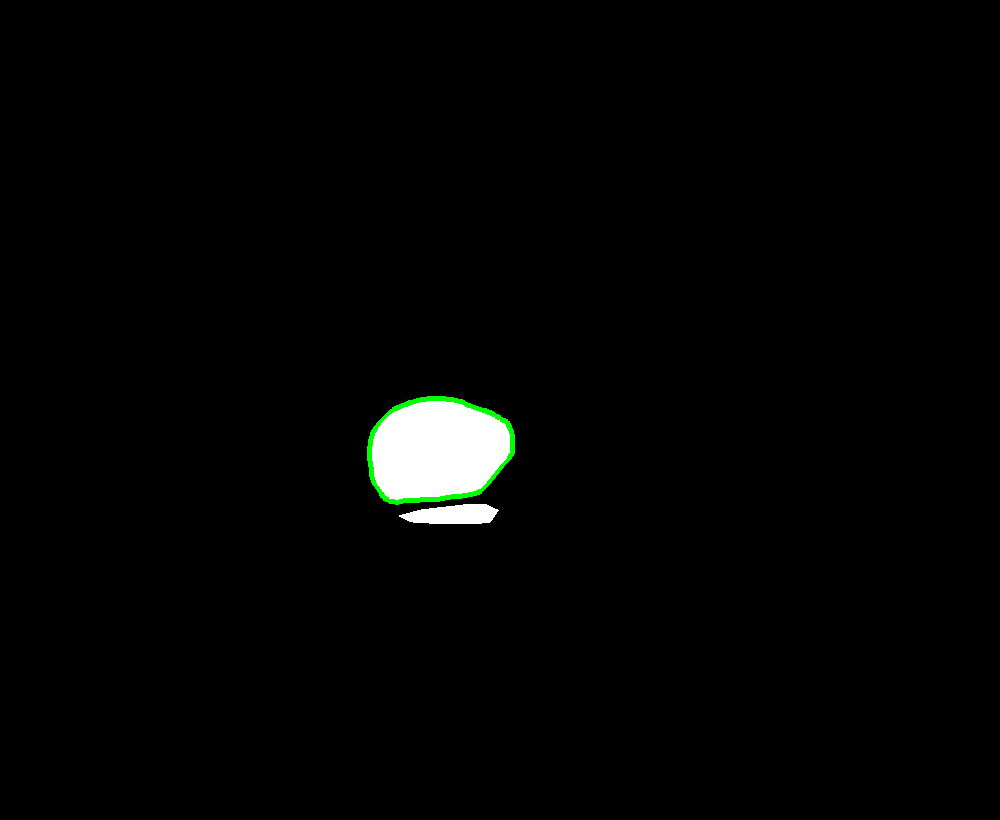

In [ ]:
# Visualize approximated mask
cv2.drawContours(binary_mask, [approx], -1, (0, 255, 0), 3)

[INFO] eps=1.0000, num_pts=1
Approx Area Difference: 11790.5
[INFO] eps=0.8889, num_pts=1
Approx Area Difference: 11790.5
[INFO] eps=0.7778, num_pts=1
Approx Area Difference: 11790.5
[INFO] eps=0.6667, num_pts=1
Approx Area Difference: 11790.5
[INFO] eps=0.5556, num_pts=1
Approx Area Difference: 11790.5
[INFO] eps=0.4445, num_pts=1
Approx Area Difference: 11790.5
[INFO] eps=0.3334, num_pts=2
Approx Area Difference: 11790.5
[INFO] eps=0.2223, num_pts=2
Approx Area Difference: 11790.5
[INFO] eps=0.1112, num_pts=4
Approx Area Difference: 3644.5
[INFO] eps=0.0001, num_pts=158
Approx Area Difference: 0.0


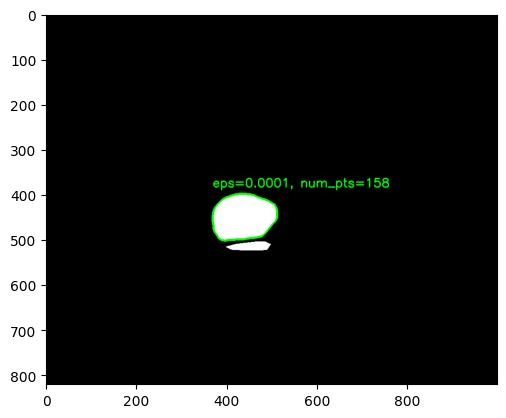

In [ ]:
# Try approx polyDP with varying epsilon sizes
# over a number of epsilon sizes
max_area = cv2.contourArea(c)
delta = 0.0001
for eps in np.linspace(1, 0.0001, 10):
  # approximate the contour
  peri = cv2.arcLength(c, True)
  approx = cv2.approxPolyDP(c, eps * peri, True)

  # draw the approximated contour on the image
  output = binary_mask.copy()
  cv2.drawContours(output, [approx], -1, (0, 255, 0), 3)
  text = "eps={:.4f}, num_pts={}".format(eps, len(approx))
  cv2.putText(output, text, (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX,
  0.9, (0, 255, 0), 2)

  # show the approximated contour image
  print("[INFO] {}".format(text))
  plt.imshow(output)

  # check if contour area is same as max area
  approx_area = cv2.contourArea(approx)
  area_diff = abs(max_area - approx_area)
  print("Approx Area Difference:", area_diff)
  if abs(max_area - approx_area) < delta:
    break

# Damage Segmentation using YOLOv11

In [ ]:
# Navigate to YOLO directory
os.chdir("/content/drive/MyDrive/CarDD_release/CarDD_COCO")

In [ ]:
# Load a model
model = YOLO("yolo11n-seg.pt")

100%|██████████| 5.90M/5.90M [00:00<00:00, 96.3MB/s]


In [ ]:
# Train the model
results = model.train(data = "dataset.yaml", epochs = 100, imgsz = 640)

Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, pro

100%|██████████| 755k/755k [00:00<00:00, 25.9MB/s]

Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

YOLO11n-seg summary: 203 layers, 2,843,973 parameters, 2,843,957 gradients, 10.4 GFLOPs

Transferred 510/561 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 91.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.6±0.1 ms, read: 1.7±0.3 MB/s, size: 771.1 KB)


train: Scanning /content/drive/MyDrive/CarDD_release/CarDD_COCO/labels/train... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [18:36<00:00,  2.52it/s]


train: New cache created: /content/drive/MyDrive/CarDD_release/CarDD_COCO/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 1.5±0.5 MB/s, size: 618.6 KB)


val: Scanning /content/drive/MyDrive/CarDD_release/CarDD_COCO/labels/val... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [05:34<00:00,  2.42it/s]


val: New cache created: /content/drive/MyDrive/CarDD_release/CarDD_COCO/labels/val.cache
Plotting labels to runs/segment/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.82G      1.424      3.153      3.271       1.54         97        640: 100%|██████████| 176/176 [01:55<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:21<00:00,  1.23it/s]


                   all        810       1744      0.657      0.422       0.46      0.343      0.643      0.413      0.445      0.327

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.92G      1.434      2.806      2.391      1.529         77        640: 100%|██████████| 176/176 [01:46<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.36it/s]


                   all        810       1744      0.352      0.451      0.414      0.297       0.37      0.447      0.405      0.285

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.93G      1.445      2.821      2.235      1.522         64        640: 100%|██████████| 176/176 [01:44<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.34it/s]


                   all        810       1744      0.536      0.446      0.444      0.302      0.521      0.437      0.422      0.263

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.95G      1.414      2.783      2.116      1.505         54        640: 100%|██████████| 176/176 [01:44<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.35it/s]


                   all        810       1744      0.492      0.452      0.451      0.333      0.492      0.446       0.44      0.304

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.97G      1.409      2.715      2.008      1.481         80        640: 100%|██████████| 176/176 [01:43<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.31it/s]


                   all        810       1744      0.494      0.474      0.468       0.32      0.503      0.464      0.459      0.318

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.98G       1.36      2.658      1.901      1.457         74        640: 100%|██████████| 176/176 [01:43<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


                   all        810       1744      0.584      0.452      0.498      0.373      0.614      0.441      0.487      0.362

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100         4G      1.335      2.616      1.817      1.439         93        640: 100%|██████████| 176/176 [01:43<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.33it/s]


                   all        810       1744      0.535      0.497      0.516      0.379       0.53      0.489      0.508      0.374

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.01G      1.323      2.583      1.797      1.423         83        640: 100%|██████████| 176/176 [01:43<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


                   all        810       1744      0.663      0.535      0.572      0.432      0.613      0.531      0.562      0.419

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.03G      1.283      2.516      1.733      1.415         76        640: 100%|██████████| 176/176 [01:43<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


                   all        810       1744      0.602       0.53      0.548      0.418      0.584      0.516      0.531      0.398

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.05G      1.286      2.516      1.691      1.397         76        640: 100%|██████████| 176/176 [01:44<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.49it/s]


                   all        810       1744      0.521      0.556      0.532      0.411       0.61      0.503      0.529      0.401

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.06G      1.268       2.45      1.652      1.387         68        640: 100%|██████████| 176/176 [01:42<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.31it/s]


                   all        810       1744      0.527       0.56       0.56      0.423      0.534      0.562      0.553      0.412

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.08G      1.248      2.446      1.618      1.367         79        640: 100%|██████████| 176/176 [01:42<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]


                   all        810       1744       0.57      0.567      0.572      0.448      0.576       0.56      0.566      0.429

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.09G      1.246      2.407      1.594      1.366         63        640: 100%|██████████| 176/176 [01:43<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]


                   all        810       1744      0.599      0.569      0.598      0.454       0.58      0.557      0.582      0.436

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.11G      1.228      2.386      1.568      1.362         97        640: 100%|██████████| 176/176 [01:43<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]


                   all        810       1744       0.61      0.561      0.591      0.452      0.601      0.558      0.582      0.433

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.13G      1.213      2.355      1.526      1.347         60        640: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.34it/s]


                   all        810       1744      0.572      0.611      0.596      0.466      0.582      0.589       0.58      0.427

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.14G       1.21      2.388      1.522      1.348         81        640: 100%|██████████| 176/176 [01:42<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


                   all        810       1744      0.536      0.587      0.592      0.448      0.531      0.561      0.576      0.424

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.16G       1.21      2.349      1.516      1.342         82        640: 100%|██████████| 176/176 [01:42<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


                   all        810       1744      0.617      0.565      0.603      0.461      0.612      0.555      0.591      0.443

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.18G      1.167      2.287      1.456      1.316         84        640: 100%|██████████| 176/176 [01:43<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


                   all        810       1744      0.646      0.585      0.624      0.478      0.625       0.58      0.613      0.461

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.19G      1.192      2.298      1.466       1.33         67        640: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.33it/s]


                   all        810       1744       0.61      0.594      0.609      0.467      0.695       0.56      0.602      0.449

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.21G      1.154      2.258      1.425      1.307         73        640: 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.47it/s]


                   all        810       1744      0.642      0.587      0.615      0.477        0.6      0.599      0.602      0.457

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.22G      1.159      2.234      1.424      1.317         90        640: 100%|██████████| 176/176 [01:44<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.47it/s]


                   all        810       1744      0.663      0.618      0.638      0.504      0.659      0.617       0.63      0.485

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.24G      1.145      2.218      1.394      1.298         81        640: 100%|██████████| 176/176 [01:44<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


                   all        810       1744      0.618      0.642      0.647      0.508      0.598      0.631       0.63      0.482

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.26G      1.145      2.244      1.409      1.301         70        640: 100%|██████████| 176/176 [01:43<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.33it/s]


                   all        810       1744      0.646      0.603      0.644        0.5      0.654      0.595      0.632      0.485

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.28G      1.125      2.183      1.345      1.287         80        640: 100%|██████████| 176/176 [01:42<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


                   all        810       1744      0.644      0.605      0.633      0.491      0.633      0.598      0.622      0.478

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.29G      1.134      2.182      1.348      1.293         77        640: 100%|██████████| 176/176 [01:43<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.47it/s]


                   all        810       1744      0.706      0.613      0.653      0.514        0.7      0.608      0.642      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.31G      1.131      2.174      1.342      1.283         54        640: 100%|██████████| 176/176 [01:42<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


                   all        810       1744      0.648      0.618       0.64      0.505      0.653      0.616       0.63      0.483

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.32G      1.102      2.152      1.306      1.267         89        640: 100%|██████████| 176/176 [01:42<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.35it/s]


                   all        810       1744      0.659      0.633      0.656      0.498      0.648      0.626      0.643      0.482

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.34G      1.104      2.141      1.299      1.271         61        640: 100%|██████████| 176/176 [01:42<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]


                   all        810       1744      0.632      0.673      0.667      0.523      0.625      0.663      0.653      0.494

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.36G      1.118       2.15        1.3       1.27         72        640: 100%|██████████| 176/176 [01:44<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


                   all        810       1744       0.69      0.637      0.671      0.522      0.698      0.635      0.664        0.5

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.38G      1.097      2.111       1.28      1.256         75        640: 100%|██████████| 176/176 [01:44<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.51it/s]

                   all        810       1744      0.662      0.628      0.665      0.522      0.652      0.622      0.652        0.5



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.39G      1.103        2.1        1.3       1.26         53        640: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.37it/s]


                   all        810       1744      0.624      0.654      0.654      0.509      0.616      0.649      0.641      0.488

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.41G      1.091      2.106      1.268      1.258         89        640: 100%|██████████| 176/176 [01:39<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


                   all        810       1744      0.681      0.628      0.667      0.523      0.674      0.629      0.657      0.497

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.42G      1.073      2.069      1.242      1.237         67        640: 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]


                   all        810       1744      0.627      0.642      0.662      0.518      0.625      0.641      0.653      0.494

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.44G      1.073      2.077      1.233      1.247         74        640: 100%|██████████| 176/176 [01:43<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]


                   all        810       1744      0.736      0.622      0.672      0.528      0.713      0.632       0.66      0.504

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.46G      1.068      2.061      1.222      1.241         74        640: 100%|██████████| 176/176 [01:42<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.50it/s]


                   all        810       1744      0.697      0.658      0.684      0.533      0.693      0.653      0.669      0.507

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.47G      1.066      2.061      1.219      1.236         66        640: 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


                   all        810       1744      0.673      0.641      0.663      0.506      0.663      0.643      0.653      0.489

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.49G      1.051      2.036      1.198       1.23         60        640: 100%|██████████| 176/176 [01:40<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


                   all        810       1744      0.705      0.654      0.691       0.54      0.708      0.637      0.676      0.518

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100       4.5G      1.058       2.04      1.182      1.228         89        640: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


                   all        810       1744      0.666      0.651      0.668      0.523      0.674      0.641      0.656      0.501

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.52G       1.04      2.003      1.172      1.217         77        640: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]


                   all        810       1744      0.712      0.654      0.691      0.535      0.738      0.633      0.677      0.512

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.54G      1.038      1.991      1.158      1.215         76        640: 100%|██████████| 176/176 [01:42<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]


                   all        810       1744      0.717      0.665      0.697      0.542       0.72      0.656      0.681      0.518

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.55G      1.028      1.978      1.153      1.214         70        640: 100%|██████████| 176/176 [01:40<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.34it/s]


                   all        810       1744      0.688      0.672      0.688      0.546      0.685      0.667      0.677      0.519

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.57G      1.033      1.986      1.141      1.214         91        640: 100%|██████████| 176/176 [01:40<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


                   all        810       1744        0.7      0.662      0.688      0.539      0.681      0.669      0.676      0.512

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.58G      1.027       1.98      1.134      1.205         82        640: 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.49it/s]


                   all        810       1744       0.69      0.666      0.691      0.538      0.698      0.654      0.678      0.515

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100       4.6G       1.02      1.956      1.121      1.201         71        640: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


                   all        810       1744      0.709      0.672      0.697      0.545      0.707       0.67      0.683       0.52

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.62G      1.009      1.943      1.103      1.199         81        640: 100%|██████████| 176/176 [01:42<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]


                   all        810       1744      0.698       0.68      0.702      0.546      0.701      0.669      0.688      0.523

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.63G      1.007      1.936      1.089      1.195         85        640: 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.36it/s]


                   all        810       1744      0.715      0.671      0.694      0.549      0.723      0.673       0.69      0.525

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.65G      1.004      1.918      1.091      1.194         62        640: 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.33it/s]


                   all        810       1744      0.673      0.671      0.687      0.542      0.675      0.664      0.682      0.518

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.66G     0.9953      1.915      1.063      1.187         87        640: 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]


                   all        810       1744      0.699       0.67      0.689      0.546      0.719      0.653      0.676      0.521

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.68G       1.01      1.914       1.08      1.195         82        640: 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.51it/s]


                   all        810       1744      0.721      0.663      0.701      0.553      0.713      0.656      0.685      0.524

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100       4.7G      1.005      1.937      1.087      1.191         81        640: 100%|██████████| 176/176 [01:43<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.52it/s]


                   all        810       1744      0.696      0.678        0.7       0.55      0.697      0.668      0.687      0.525

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.71G     0.9865      1.892      1.057      1.178         75        640: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


                   all        810       1744      0.714      0.671      0.703      0.557        0.7      0.665       0.69      0.523

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.73G      1.004      1.886      1.051      1.186         82        640: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.36it/s]

                   all        810       1744      0.736      0.665      0.706      0.558      0.749      0.648      0.693      0.533



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.75G     0.9906      1.887      1.053      1.179         87        640: 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


                   all        810       1744      0.712      0.665      0.695      0.551      0.714      0.655      0.683      0.522

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.76G     0.9683      1.848      1.015      1.169         64        640: 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.49it/s]


                   all        810       1744      0.747      0.659      0.707      0.561      0.733      0.648      0.686      0.534

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.78G      0.966      1.836      1.015      1.171         85        640: 100%|██████████| 176/176 [01:42<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]

                   all        810       1744      0.724      0.673      0.722      0.574      0.726      0.665      0.709      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.79G      0.958       1.82      1.007      1.161         69        640: 100%|██████████| 176/176 [01:43<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.49it/s]

                   all        810       1744      0.701      0.703      0.708      0.561        0.7      0.702      0.699      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.81G     0.9601      1.824     0.9883      1.166         57        640: 100%|██████████| 176/176 [01:40<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


                   all        810       1744      0.699      0.688      0.706      0.558      0.706      0.671      0.695      0.534

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.83G     0.9545      1.836     0.9782      1.155         77        640: 100%|██████████| 176/176 [01:40<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


                   all        810       1744      0.705        0.7      0.718       0.57      0.713      0.677      0.701      0.539

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.84G     0.9543      1.829     0.9883      1.156         79        640: 100%|██████████| 176/176 [01:40<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


                   all        810       1744      0.728      0.689      0.709      0.566      0.727      0.681      0.698      0.534

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.86G     0.9561       1.82     0.9778      1.156         78        640: 100%|██████████| 176/176 [01:42<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]


                   all        810       1744       0.74      0.682      0.718      0.565      0.766      0.673      0.708      0.539

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.88G     0.9407      1.815     0.9633      1.152         97        640: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]

                   all        810       1744      0.732      0.692      0.715       0.57      0.719      0.686      0.702      0.539



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.89G     0.9576      1.805     0.9726      1.152         84        640: 100%|██████████| 176/176 [01:40<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.36it/s]

                   all        810       1744      0.742      0.675      0.715      0.561       0.74      0.673      0.706      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.91G     0.9193      1.743     0.9234       1.13         83        640: 100%|██████████| 176/176 [01:40<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.52it/s]


                   all        810       1744      0.733      0.682      0.713       0.57      0.723      0.688      0.707      0.543

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.92G     0.9371      1.775     0.9415      1.142         85        640: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.50it/s]


                   all        810       1744      0.722      0.702      0.726      0.578       0.74      0.688      0.723      0.553

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.95G     0.9263      1.765     0.9237      1.135         67        640: 100%|██████████| 176/176 [01:40<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.41it/s]

                   all        810       1744      0.737      0.676      0.713      0.565      0.741      0.677      0.707      0.539



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.96G     0.9364      1.781     0.9268      1.138         59        640: 100%|██████████| 176/176 [01:39<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]


                   all        810       1744       0.74      0.691      0.724      0.571      0.743      0.685       0.71       0.54

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.97G     0.9182      1.759     0.9165      1.129         75        640: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.47it/s]

                   all        810       1744      0.743       0.69      0.721      0.571      0.752      0.686      0.718      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.99G     0.9111       1.72     0.8952      1.124         62        640: 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.47it/s]


                   all        810       1744      0.726      0.692      0.728      0.578      0.729      0.687      0.722      0.548

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100         5G     0.9045      1.705     0.8918      1.121         58        640: 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


                   all        810       1744      0.731      0.711      0.726      0.577      0.719      0.703       0.71      0.547

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.02G     0.9099      1.726     0.8892      1.122         97        640: 100%|██████████| 176/176 [01:40<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]

                   all        810       1744      0.724      0.703      0.734       0.58      0.748      0.684      0.722      0.553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.04G     0.9006      1.692     0.8803      1.118         70        640: 100%|██████████| 176/176 [01:43<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]


                   all        810       1744      0.727      0.703      0.725      0.577      0.722      0.699      0.719       0.55

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.05G     0.8988      1.704     0.8608      1.118         76        640: 100%|██████████| 176/176 [01:42<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]

                   all        810       1744      0.738      0.694      0.729       0.58       0.74      0.693       0.72      0.549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.07G     0.8943      1.699     0.8514      1.112         70        640: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]

                   all        810       1744      0.737      0.708      0.734      0.581      0.752      0.693      0.725      0.552



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.09G     0.8828      1.671     0.8517      1.106         73        640: 100%|██████████| 176/176 [01:40<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.34it/s]

                   all        810       1744      0.737      0.688      0.721      0.575      0.731      0.686      0.711      0.546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100       5.1G     0.8763      1.656     0.8355      1.098         93        640: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]

                   all        810       1744      0.748      0.695      0.731      0.579      0.747      0.687      0.719      0.545



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.12G     0.8813      1.673     0.8454      1.105         78        640: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.51it/s]


                   all        810       1744      0.741      0.692      0.723      0.576      0.741      0.683      0.715      0.547

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.14G     0.8708      1.671     0.8352      1.105         75        640: 100%|██████████| 176/176 [01:42<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]

                   all        810       1744      0.725      0.707      0.733      0.583      0.752      0.681      0.716      0.553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.15G      0.877      1.647     0.8289      1.099         93        640: 100%|██████████| 176/176 [01:40<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


                   all        810       1744      0.757      0.695      0.729      0.585       0.75      0.689      0.711      0.549

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.17G     0.8727      1.654     0.8288        1.1         74        640: 100%|██████████| 176/176 [01:43<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.32it/s]


                   all        810       1744      0.743      0.714       0.73      0.585      0.741      0.704      0.722      0.554

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.18G     0.8647       1.63     0.8075      1.096         95        640: 100%|██████████| 176/176 [01:40<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]

                   all        810       1744      0.785      0.674      0.732      0.588      0.782      0.672      0.724      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100       5.2G     0.8613      1.617     0.8023      1.093         82        640: 100%|██████████| 176/176 [01:42<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]

                   all        810       1744      0.765      0.706      0.737      0.587      0.761        0.7      0.725      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.21G      0.843       1.59     0.7913      1.084         79        640: 100%|██████████| 176/176 [01:43<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]


                   all        810       1744      0.747      0.717      0.733      0.583      0.747       0.71      0.722      0.553

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.23G       0.86        1.6     0.7836      1.089         67        640: 100%|██████████| 176/176 [01:42<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.44it/s]

                   all        810       1744      0.755        0.7      0.735      0.584      0.738      0.698       0.72      0.552



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.25G     0.8676       1.62     0.7921       1.09         79        640: 100%|██████████| 176/176 [01:42<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.36it/s]

                   all        810       1744       0.75      0.707      0.732      0.583       0.76      0.689      0.717       0.55



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.27G     0.8471      1.606     0.7771      1.085         71        640: 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


                   all        810       1744      0.753      0.711      0.734      0.581      0.749      0.707      0.719      0.549

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.28G     0.8495      1.608     0.7782      1.084         69        640: 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.49it/s]


                   all        810       1744      0.735      0.711       0.73      0.584      0.731      0.707      0.718      0.552

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100       5.3G     0.8515      1.591     0.7766      1.083         63        640: 100%|██████████| 176/176 [01:42<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]

                   all        810       1744      0.754      0.712      0.735      0.582      0.753      0.708      0.726      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.31G     0.8446       1.59     0.7706      1.078         93        640: 100%|██████████| 176/176 [01:40<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]

                   all        810       1744       0.77      0.697      0.734      0.585      0.761      0.699      0.723      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.33G     0.8376      1.579     0.7532      1.072         71        640: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]

                   all        810       1744      0.757        0.7      0.737      0.584      0.755      0.693      0.722      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.35G     0.8274      1.563     0.7542      1.072         71        640: 100%|██████████| 176/176 [01:40<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]

                   all        810       1744      0.745      0.714      0.736      0.589      0.757      0.704      0.727      0.558


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.38G     0.8295      1.527     0.7133      1.075         31        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]

                   all        810       1744      0.773       0.68      0.725      0.577      0.767      0.676      0.711      0.547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.39G     0.7927      1.454     0.6444      1.055         36        640: 100%|██████████| 176/176 [01:36<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]

                   all        810       1744      0.747      0.705      0.729      0.578      0.748      0.694      0.718      0.549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.41G     0.7899      1.452     0.6328      1.053         26        640: 100%|██████████| 176/176 [01:35<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


                   all        810       1744      0.746      0.712      0.728       0.58      0.749      0.706       0.72      0.549

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.43G     0.7821       1.44     0.6242      1.048         33        640: 100%|██████████| 176/176 [01:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.40it/s]

                   all        810       1744      0.751      0.711      0.733      0.584      0.754      0.703      0.726      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.44G      0.769      1.415     0.6024      1.038         40        640: 100%|██████████| 176/176 [01:34<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.47it/s]


                   all        810       1744      0.775      0.696      0.735      0.585      0.776      0.686      0.725      0.552

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.46G     0.7647      1.409     0.5988      1.037         46        640: 100%|██████████| 176/176 [01:35<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.37it/s]

                   all        810       1744      0.761      0.702       0.73      0.584      0.779      0.686      0.721      0.553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.47G     0.7612      1.383     0.5884      1.028         29        640: 100%|██████████| 176/176 [01:35<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]

                   all        810       1744      0.782      0.689      0.731      0.583      0.778      0.685      0.718      0.553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.49G     0.7598      1.389     0.5827      1.033         47        640: 100%|██████████| 176/176 [01:35<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.49it/s]


                   all        810       1744       0.77      0.706      0.737      0.588       0.77      0.703      0.729      0.556

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100       5.5G      0.755      1.379     0.5767      1.026         32        640: 100%|██████████| 176/176 [01:35<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.36it/s]

                   all        810       1744      0.769      0.711      0.739       0.59      0.773      0.698      0.724      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.52G     0.7545      1.374     0.5788      1.026         36        640: 100%|██████████| 176/176 [01:36<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]


                   all        810       1744      0.791      0.698       0.74      0.588      0.783      0.687      0.723      0.556

100 epochs completed in 3.369 hours.
Optimizer stripped from runs/segment/train4/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train4/weights/best.pt, 6.0MB

Validating runs/segment/train4/weights/best.pt...
Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,835,933 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/26 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 1/26 [00:00<00:10,  2.36it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   8%|▊         | 2/26 [00:01<00:22,  1.08it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:20<00:00,  1.29it/s]


                   all        810       1744      0.746      0.714      0.737       0.59      0.744      0.711      0.727      0.558
                  dent        352        501      0.668      0.569      0.622      0.348      0.662      0.561      0.604      0.307
               scratch        431        728      0.601      0.544      0.558      0.322      0.604      0.545      0.546      0.278
                 crack        122        177      0.506      0.412      0.387      0.207      0.495      0.399      0.362      0.136
         glass shatter        134        135      0.995      0.978      0.991      0.949      0.995      0.978      0.991      0.926
           lamp broken        139        141      0.793       0.83      0.882      0.775      0.793       0.83      0.882      0.768
             tire flat         59         62      0.914      0.952      0.979      0.936      0.914      0.952      0.979      0.933
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 5.1ms postproce

In [ ]:
# Load best model after train
model = YOLO("/content/drive/MyDrive/CarDD_release/CarDD_COCO/runs/segment/train4/weights/best.pt")

In [ ]:
# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map  # map50-95(B)
metrics.box.map50  # map50(B)
metrics.box.map75  # map75(B)
metrics.box.maps  # a list contains map50-95(B) of each category
metrics.seg.map  # map50-95(M)
metrics.seg.map50  # map50(M)
metrics.seg.map75  # map75(M)
metrics.seg.maps  # a list contains map50-95(M) of each category

Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,835,933 parameters, 0 gradients, 10.2 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 248.1±68.7 MB/s, size: 765.0 KB)


val: Scanning /content/drive/MyDrive/CarDD_release/CarDD_COCO/labels/val.cache... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/51 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/51 [00:04<03:47,  4.54s/it]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/51 [00:05<02:03,  2.51s/it]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:26<00:00,  1.90it/s]


                   all        810       1744      0.747      0.711      0.734      0.587      0.765      0.693      0.724      0.556
                  dent        352        501      0.666      0.569       0.62      0.347      0.701      0.548      0.604      0.307
               scratch        431        728      0.599      0.544      0.557      0.323      0.631      0.512      0.549      0.276
                 crack        122        177      0.506      0.412      0.387      0.205      0.523      0.362      0.355      0.134
         glass shatter        134        135      0.996      0.978      0.988      0.948      0.999      0.978      0.985      0.925
           lamp broken        139        141      0.802       0.83      0.878      0.771      0.811      0.824      0.878      0.765
             tire flat         59         62      0.912      0.935      0.975       0.93      0.922      0.935      0.975       0.93
Speed: 0.6ms preprocess, 7.5ms inference, 0.0ms loss, 4.6ms postproce

array([    0.55622,      0.3069,      0.2763,     0.13382,     0.92529,     0.76514,     0.92986])

In [ ]:
# Predict and test model on unseen data
results = model(["damaged-car-for-salvage.jpg"])  # predict on an image

# Access the results
for result in results:
    xy = result.masks.xy  # mask in polygon format
    xyn = result.masks.xyn  # normalized
    masks = result.masks.data  # mask in matrix format (num_objects x H x W)


0: 384x640 2 dents, 1 scratch, 55.8ms
Speed: 25.9ms preprocess, 55.8ms inference, 399.7ms postprocess per image at shape (1, 3, 384, 640)


Mask Area: 37706 pixels
Total Area: 245760 pixels
Mask Area Ratio: 0.15342610677083332


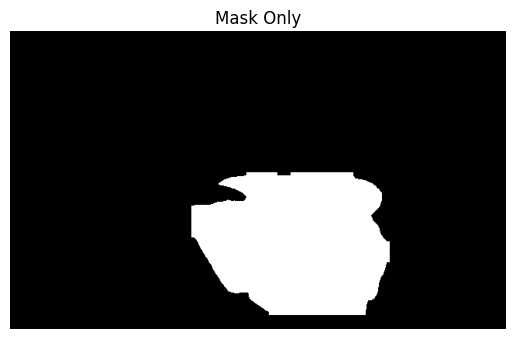

In [ ]:
# prompt: Visualize mask only from results

import matplotlib.pyplot as plt
# Display mask
mask_image = masks[0].cpu().numpy() # Convert mask tensor to numpy array
area = cv2.countNonZero(mask_image)
total_area = mask_image.shape[0] * mask_image.shape[1]
print(f"Mask Area: {area} pixels")
print(f"Total Area: {total_area} pixels")
print(f"Mask Area Ratio: {area / total_area}")
plt.imshow(mask_image, cmap='gray')  # Use gray colormap for binary mask
plt.title("Mask Only")
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
# Example: Get class names for predicted class IDs
id2class = results[0].names
predicted_class_ids = list(results[0].boxes.cls)
predicted_class_names = [id2class[int(class_id)] for class_id in predicted_class_ids]
unique_class_names = list(set(predicted_class_names))
cost_lookup = {'scratch': 50, 'dent': 100, 'crack':200}
total_cost = 0

for class_name in unique_class_names:
    count = predicted_class_names.count(class_name)
    cost = count * cost_lookup[class_name]
    total_cost += cost
    print(f"{class_name}: {count} - Cost: ${cost}")

print(f"Total Cost: ${total_cost}")
print("Predicted Class IDs:", predicted_class_ids)
print("Predicted Class Names:", predicted_class_names)

scratch: 1 - Cost: $50
dent: 2 - Cost: $200
Total Cost: $250
Predicted Class IDs: [tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(2., device='cuda:0')]
Predicted Class Names: ['dent', 'dent', 'scratch']


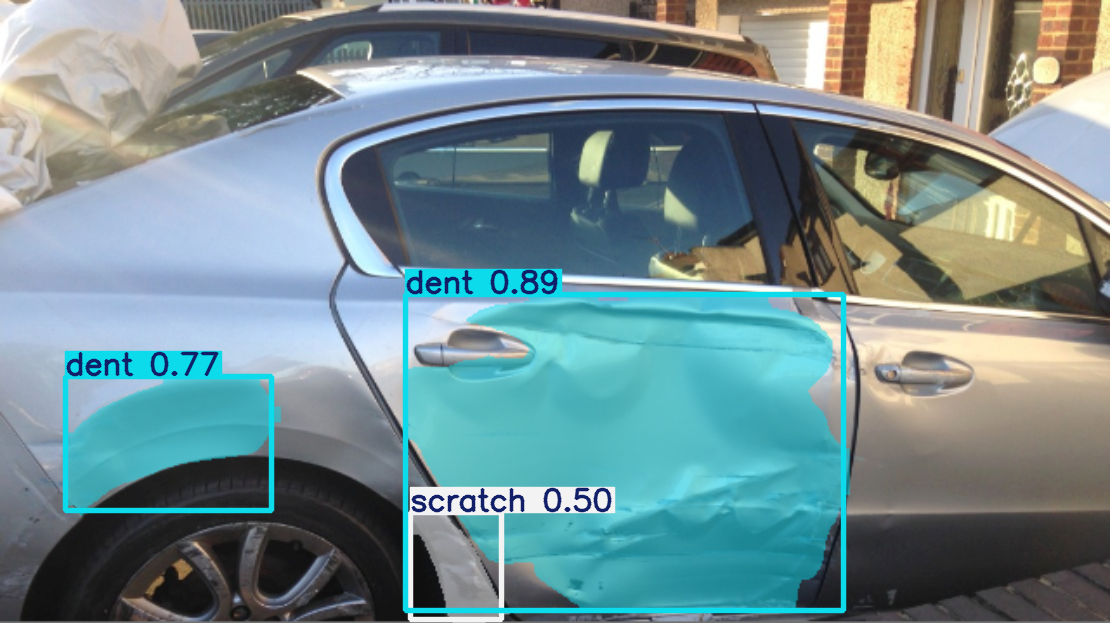

In [ ]:
# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    probs = result.probs  # Probs object for classification outputs
    result.show()  # display to screen
    result.save(filename = "result.jpg")  # save to disk

In [ ]:
# Export the evaluated model
model.export(format = "onnx")

Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'runs/segment/train4/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 43, 8400), (1, 32, 160, 160)) (5.7 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.56', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 8.9s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.58...
ONNX: export success ✅ 11.7s, saved as 'runs/segment/train4/weights/best.onnx' (11.1 MB)

Export complete (13.1s)
Results saved to /content/drive/MyDrive/CarDD_release/CarDD_COCO/runs/segment/train4/weights
Predict:         yolo predict task=segment model=runs

'runs/segment/train4/weights/best.onnx'

# Damage Segmentation using Tuned YOLOv11

In [ ]:
# Navigate to YOLO directory
os.chdir("/content/drive/MyDrive/CarDD_release/CarDD_COCO")

In [ ]:
# Load a model
model = YOLO("yolo11n-seg.pt")

In [ ]:
# Train the model
results = model.train(data = "dataset.yaml", epochs = 100, imgsz = 640, multi_scale = True)

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=True, name=train7, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, prof

100%|██████████| 755k/755k [00:00<00:00, 86.1MB/s]

Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

YOLO11n-seg summary: 203 layers, 2,843,973 parameters, 2,843,957 gradients, 10.4 GFLOPs

Transferred 510/561 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.1 ms, read: 0.7±0.2 MB/s, size: 771.1 KB)


train: Scanning /content/drive/MyDrive/CarDD_release/CarDD_COCO/labels/train.cache... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 0.9±0.2 MB/s, size: 618.6 KB)


val: Scanning /content/drive/MyDrive/CarDD_release/CarDD_COCO/labels/val.cache... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<?, ?it/s]


Plotting labels to runs/segment/train7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train7
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.28G      1.491      3.367      3.467       1.59         97        576: 100%|██████████| 176/176 [36:21<00:00, 12.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [08:15<00:00, 19.06s/it]


                   all        810       1744      0.585      0.388      0.394      0.293      0.578      0.383      0.386      0.278

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100       7.3G      1.518       3.02      2.679      1.593         77        800: 100%|██████████| 176/176 [01:49<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


                   all        810       1744      0.342      0.378      0.352      0.246      0.343      0.377      0.345      0.239

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.32G      1.535      3.043      2.481      1.593         64        352: 100%|██████████| 176/176 [01:49<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.30it/s]


                   all        810       1744       0.64      0.415      0.447      0.312      0.636      0.398      0.432      0.294

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.32G      1.516       2.98      2.288      1.563         54        672: 100%|██████████| 176/176 [01:47<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


                   all        810       1744      0.486      0.436      0.452      0.321      0.463      0.428      0.438      0.315

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.33G      1.485      2.909      2.164      1.537         80        480: 100%|██████████| 176/176 [01:47<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:20<00:00,  1.28it/s]


                   all        810       1744       0.48      0.467      0.474      0.343      0.482       0.45      0.457      0.318

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.35G       1.43      2.841       2.05       1.51         74        416: 100%|██████████| 176/176 [01:47<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


                   all        810       1744      0.612      0.435      0.505      0.362      0.601      0.431      0.497      0.339

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.35G      1.402      2.781      1.967      1.488         93        768: 100%|██████████| 176/176 [01:47<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


                   all        810       1744      0.738      0.458      0.505      0.367      0.595      0.453      0.489      0.356

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.35G      1.376      2.771      1.911      1.474         83        896: 100%|██████████| 176/176 [01:50<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


                   all        810       1744      0.776      0.405      0.471      0.364      0.795        0.4      0.464      0.353

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.35G      1.361      2.716      1.884      1.462         76        672: 100%|██████████| 176/176 [01:48<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


                   all        810       1744      0.576      0.508      0.534      0.404       0.57      0.496      0.518      0.385

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.35G      1.348      2.682      1.813      1.449         76        864: 100%|██████████| 176/176 [01:48<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


                   all        810       1744      0.603      0.508      0.532      0.411       0.59      0.506       0.52       0.39

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.35G      1.333      2.641      1.775      1.448         68        736: 100%|██████████| 176/176 [01:46<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


                   all        810       1744      0.662      0.508      0.569      0.441      0.722      0.507      0.553      0.421

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.35G      1.313      2.656      1.734      1.414         79        544: 100%|██████████| 176/176 [01:47<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


                   all        810       1744      0.565      0.577      0.575      0.433       0.56      0.566       0.56      0.407

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.35G      1.305      2.595      1.707      1.421         63        672: 100%|██████████| 176/176 [01:47<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]


                   all        810       1744      0.637      0.537      0.586       0.45      0.593      0.531      0.562      0.418

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.35G      1.274       2.59      1.677       1.39         97        832: 100%|██████████| 176/176 [01:47<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.47it/s]


                   all        810       1744       0.58      0.593      0.588       0.44      0.583       0.58      0.569      0.416

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.35G      1.277      2.551      1.644      1.399         60        512: 100%|██████████| 176/176 [01:46<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


                   all        810       1744      0.618        0.6      0.596       0.47      0.599      0.577      0.574      0.437

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.35G      1.267       2.57      1.623      1.398         81        672: 100%|██████████| 176/176 [01:45<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:21<00:00,  1.23it/s]


                   all        810       1744      0.594      0.592       0.61       0.47      0.605      0.587      0.598      0.437

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.35G      1.267       2.54      1.614       1.39         82        480: 100%|██████████| 176/176 [01:46<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.31it/s]


                   all        810       1744      0.569      0.604      0.608      0.476      0.582      0.579      0.591      0.446

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.35G      1.238      2.498      1.576      1.377         84        608: 100%|██████████| 176/176 [01:46<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:20<00:00,  1.30it/s]


                   all        810       1744      0.624      0.569      0.602      0.472      0.619      0.555      0.583      0.445

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.35G       1.24      2.476      1.575      1.378         67        832: 100%|██████████| 176/176 [01:46<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.33it/s]


                   all        810       1744      0.609      0.598      0.617      0.472      0.627      0.553       0.59      0.439

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.35G      1.228       2.47      1.539      1.358         73        384: 100%|██████████| 176/176 [01:44<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


                   all        810       1744      0.579      0.586      0.609      0.477      0.628      0.553      0.593      0.445

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.35G      1.218      2.469      1.528      1.357         90        416: 100%|██████████| 176/176 [01:46<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.33it/s]


                   all        810       1744      0.663      0.603      0.633      0.499      0.653      0.594      0.614      0.463

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.35G      1.203      2.432      1.498      1.348         81        928: 100%|██████████| 176/176 [01:44<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


                   all        810       1744      0.629      0.618      0.634      0.494      0.614      0.607      0.612      0.461

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.35G      1.208      2.453      1.505      1.352         70        352: 100%|██████████| 176/176 [01:47<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


                   all        810       1744      0.582       0.63      0.624      0.494      0.584      0.628      0.613      0.468

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.35G      1.177      2.396      1.447      1.329         80        800: 100%|██████████| 176/176 [01:46<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]


                   all        810       1744      0.645      0.584      0.622      0.495      0.625      0.569      0.603      0.463

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.35G      1.198      2.411       1.46      1.336         77        576: 100%|██████████| 176/176 [01:47<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


                   all        810       1744      0.595      0.622      0.629        0.5       0.58      0.613      0.611      0.465

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.35G      1.195        2.4      1.442      1.328         54        800: 100%|██████████| 176/176 [01:47<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


                   all        810       1744      0.651      0.618      0.647      0.501      0.635      0.609      0.626      0.469

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.35G      1.158      2.352        1.4      1.304         89        928: 100%|██████████| 176/176 [01:49<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


                   all        810       1744       0.67      0.621      0.644      0.501      0.656      0.612      0.627      0.473

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.35G      1.173      2.376      1.428      1.323         61        832: 100%|██████████| 176/176 [01:46<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


                   all        810       1744      0.652      0.643      0.657      0.518      0.642      0.628      0.639      0.497

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.35G      1.182      2.387      1.424      1.313         72        896: 100%|██████████| 176/176 [01:45<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:23<00:00,  1.13it/s]


                   all        810       1744      0.678      0.623      0.652       0.51      0.656      0.612       0.63      0.477

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.35G      1.153      2.324      1.385      1.303         75        512: 100%|██████████| 176/176 [01:47<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


                   all        810       1744      0.641      0.631      0.656      0.525      0.643      0.615      0.634      0.492

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.35G      1.166      2.322      1.398       1.31         53        448: 100%|██████████| 176/176 [01:46<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


                   all        810       1744      0.658      0.613      0.645      0.509       0.64      0.604      0.621      0.474

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.35G      1.151      2.332      1.367      1.306         89        800: 100%|██████████| 176/176 [01:49<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.32it/s]


                   all        810       1744      0.646      0.635      0.654      0.518      0.625      0.625      0.634      0.485

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.35G      1.143      2.304      1.352      1.291         67        512: 100%|██████████| 176/176 [01:47<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


                   all        810       1744      0.709      0.627      0.668      0.528      0.693      0.614      0.646      0.492

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.35G       1.13      2.282      1.347      1.295         74        736: 100%|██████████| 176/176 [01:52<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.35it/s]


                   all        810       1744      0.649      0.633       0.66      0.526      0.645      0.625      0.641      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.35G      1.143      2.306      1.331      1.289         74        416: 100%|██████████| 176/176 [01:50<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:21<00:00,  1.24it/s]


                   all        810       1744      0.709      0.661       0.68      0.537      0.703       0.65      0.661      0.497

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.35G       1.14      2.284      1.328      1.294         66        448: 100%|██████████| 176/176 [01:55<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:21<00:00,  1.24it/s]


                   all        810       1744      0.633      0.644      0.649      0.521      0.663      0.601      0.634      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.35G      1.107       2.24      1.299      1.281         60        576: 100%|██████████| 176/176 [01:51<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.35it/s]


                   all        810       1744      0.696      0.658      0.681      0.539      0.707      0.642      0.661      0.501

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.36G      1.113      2.273      1.283      1.279         89        480: 100%|██████████| 176/176 [01:54<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:20<00:00,  1.27it/s]


                   all        810       1744      0.674      0.656      0.668      0.524      0.675      0.649      0.648      0.497

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.36G      1.112      2.243      1.265      1.258         77        416: 100%|██████████| 176/176 [01:52<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.34it/s]


                   all        810       1744      0.701      0.628      0.676      0.533      0.698      0.612      0.646      0.496

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.36G      1.106      2.236      1.277      1.265         76        960: 100%|██████████| 176/176 [01:53<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:20<00:00,  1.28it/s]


                   all        810       1744      0.677      0.658      0.678      0.536      0.664      0.649      0.655        0.5

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.36G        1.1      2.216      1.273      1.266         70        736: 100%|██████████| 176/176 [01:50<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.35it/s]


                   all        810       1744      0.665      0.664      0.679      0.534      0.655      0.636      0.648      0.495

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.36G      1.107      2.228      1.256       1.26         91        832: 100%|██████████| 176/176 [01:52<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:21<00:00,  1.24it/s]


                   all        810       1744      0.642      0.678      0.681      0.544      0.661      0.647       0.66      0.501

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.36G      1.103      2.211      1.258       1.26         82        736: 100%|██████████| 176/176 [01:51<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.37it/s]

                   all        810       1744      0.702      0.618      0.671      0.531      0.685      0.597      0.639       0.49



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.36G      1.102      2.207      1.255      1.262         71        416: 100%|██████████| 176/176 [01:54<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.33it/s]


                   all        810       1744      0.695      0.656      0.676      0.543       0.68      0.649      0.656      0.505

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.36G      1.078      2.183      1.224      1.245         81        640: 100%|██████████| 176/176 [01:51<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.37it/s]


                   all        810       1744      0.703      0.662      0.695      0.546      0.688      0.636      0.668      0.505

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.36G      1.076      2.187      1.208      1.238         85        960: 100%|██████████| 176/176 [01:52<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:22<00:00,  1.15it/s]


                   all        810       1744      0.682      0.655       0.68      0.539      0.681      0.653      0.665      0.504

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.36G      1.077      2.173      1.211       1.24         62        544: 100%|██████████| 176/176 [01:53<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


                   all        810       1744      0.709      0.643      0.682      0.541      0.687      0.627      0.663      0.502

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.36G      1.072      2.186      1.203      1.236         87        512: 100%|██████████| 176/176 [01:53<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.31it/s]


                   all        810       1744      0.701      0.663      0.687      0.547      0.661      0.658      0.664      0.509

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.36G       1.07      2.147      1.197      1.238         82        672: 100%|██████████| 176/176 [01:55<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


                   all        810       1744      0.704      0.657      0.691      0.552       0.71      0.638      0.669      0.511

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.36G      1.068      2.169      1.201      1.245         81        352: 100%|██████████| 176/176 [01:54<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:20<00:00,  1.29it/s]


                   all        810       1744       0.71      0.658      0.686      0.549      0.709      0.627      0.665      0.514

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.36G      1.055      2.128      1.175      1.234         75        608: 100%|██████████| 176/176 [01:56<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.34it/s]

                   all        810       1744      0.684      0.635       0.68      0.545      0.715      0.597      0.656      0.503



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.36G      1.079      2.152      1.188      1.242         82        416: 100%|██████████| 176/176 [01:54<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:20<00:00,  1.27it/s]


                   all        810       1744      0.681      0.675        0.7      0.556       0.66      0.658      0.668      0.515

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.36G      1.067      2.147      1.183      1.235         87        800: 100%|██████████| 176/176 [01:55<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:21<00:00,  1.24it/s]

                   all        810       1744      0.742      0.665      0.716      0.568      0.759      0.636      0.689       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.36G      1.038      2.107      1.136      1.212         64        736: 100%|██████████| 176/176 [01:54<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.33it/s]


                   all        810       1744      0.697      0.683      0.703      0.561      0.677      0.663      0.675      0.517

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.36G      1.037      2.099      1.145      1.223         85        576: 100%|██████████| 176/176 [01:55<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:20<00:00,  1.24it/s]


                   all        810       1744      0.699      0.672      0.703       0.56      0.678       0.67      0.679      0.518

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.36G      1.037      2.093      1.125      1.205         69        704: 100%|██████████| 176/176 [01:52<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


                   all        810       1744      0.739      0.663      0.698      0.559      0.728      0.647      0.678      0.521

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.36G      1.034      2.089      1.129      1.213         57        832: 100%|██████████| 176/176 [01:55<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.35it/s]

                   all        810       1744      0.694      0.687      0.699      0.558      0.693      0.661      0.672      0.517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.36G      1.036      2.095       1.12      1.207         77        704: 100%|██████████| 176/176 [01:53<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:21<00:00,  1.22it/s]

                   all        810       1744      0.709      0.692      0.709      0.568      0.719      0.665      0.691      0.527



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.36G      1.039      2.084      1.126      1.206         79        832: 100%|██████████| 176/176 [01:55<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


                   all        810       1744       0.71      0.673      0.705      0.563      0.708      0.653      0.679      0.518

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.36G      1.028      2.078      1.112      1.207         78        320: 100%|██████████| 176/176 [01:53<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.34it/s]


                   all        810       1744      0.718      0.694      0.715       0.57      0.696      0.675      0.682      0.525

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.36G      1.017      2.086      1.099      1.204         97        640: 100%|██████████| 176/176 [01:55<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]

                   all        810       1744      0.727      0.686      0.713      0.572      0.722      0.657      0.683      0.526



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.36G      0.965      1.995      1.001      1.171         61        640:  11%|█▏        | 20/176 [00:13<01:54,  1.37it/s]

In [ ]:
# Load best model after train
model = YOLO("/content/drive/MyDrive/CarDD_release/CarDD_COCO/runs/segment/train4/weights/best.pt")

In [ ]:
# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map  # map50-95(B)
metrics.box.map50  # map50(B)
metrics.box.map75  # map75(B)
metrics.box.maps  # a list contains map50-95(B) of each category
metrics.seg.map  # map50-95(M)
metrics.seg.map50  # map50(M)
metrics.seg.map75  # map75(M)
metrics.seg.maps  # a list contains map50-95(M) of each category

# Panel Segmentation using YOLOv11

In [5]:
# Navigate to YOLO directory
os.chdir("/content/drive/MyDrive/carparts-seg")

In [6]:
# Load a model
model = YOLO("yolo11n-seg.pt")

In [ ]:
# Train the model
results = model.train(data = "data.yaml", epochs = 100, imgsz = 640, plots = True)

Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train7, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profil

100%|██████████| 755k/755k [00:00<00:00, 18.4MB/s]

Overriding model.yaml nc=80 with nc=23

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

 20                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    687925  ultralytics.nn.modules.head.Segment          [23, 32, 64, [64, 128, 256]]  
YOLO11n-seg summary: 203 layers, 2,847,093 parameters, 2,847,077 gradients, 10.4 GFLOPs

Transferred 510/561 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.1 ms, read: 0.1±0.0 MB/s, size: 35.6 KB)


train: Scanning /content/drive/MyDrive/carparts-seg/train/labels.cache... 3156 images, 116 backgrounds, 0 corrupt: 100%|██████████| 3156/3156 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.6±0.4 ms, read: 0.1±0.0 MB/s, size: 39.3 KB)


val: Scanning /content/drive/MyDrive/carparts-seg/valid/labels.cache... 401 images, 12 backgrounds, 0 corrupt: 100%|██████████| 401/401 [00:00<?, ?it/s]


Plotting labels to runs/segment/train7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00037, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train7
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.08G      1.274      2.637      3.992      1.375         31        640: 100%|██████████| 198/198 [19:44<00:00,  5.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]

                   all        401       2042      0.662      0.146      0.148      0.106      0.664      0.147      0.149      0.101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.71G      1.118      1.992      2.582      1.226         24        640: 100%|██████████| 198/198 [01:34<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


                   all        401       2042       0.49      0.455      0.351      0.259      0.491      0.456       0.35      0.239

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.94G      1.023      1.811      1.814      1.157         54        640: 100%|██████████| 198/198 [01:32<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]


                   all        401       2042      0.377      0.495      0.416      0.307      0.378      0.494      0.421      0.291

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.95G     0.9701      1.709      1.557       1.12         26        640: 100%|██████████| 198/198 [01:30<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


                   all        401       2042      0.414      0.624      0.471      0.358      0.426      0.621      0.478       0.34

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.95G     0.9283      1.636      1.423      1.098         27        640: 100%|██████████| 198/198 [01:29<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]

                   all        401       2042      0.518      0.637      0.572       0.44      0.516      0.643      0.569      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.95G     0.8959      1.562      1.296      1.076         31        640: 100%|██████████| 198/198 [01:34<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]

                   all        401       2042      0.479      0.721      0.568      0.442      0.475      0.709      0.566      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.95G      0.875      1.507      1.224      1.062         31        640: 100%|██████████| 198/198 [01:31<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.20it/s]

                   all        401       2042      0.441      0.571      0.494      0.387      0.445      0.575      0.494      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.95G     0.8595      1.481      1.183      1.055         43        640: 100%|██████████| 198/198 [01:31<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.27it/s]

                   all        401       2042      0.493      0.706      0.562      0.436      0.489      0.711      0.565      0.418



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.96G     0.8477      1.455      1.127       1.05         30        640: 100%|██████████| 198/198 [01:31<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]

                   all        401       2042      0.547       0.67       0.59      0.472       0.55      0.674      0.597      0.453



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.96G     0.8323      1.418      1.088      1.043         33        640: 100%|██████████| 198/198 [01:34<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]


                   all        401       2042      0.428      0.701      0.493      0.394      0.428      0.697      0.496      0.377

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.97G     0.8199      1.415       1.07      1.037         54        640: 100%|██████████| 198/198 [01:32<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]

                   all        401       2042      0.514      0.667      0.566      0.458      0.512      0.669      0.568      0.437



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.97G      0.814      1.383      1.022      1.032         45        640: 100%|██████████| 198/198 [01:31<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]

                   all        401       2042      0.476      0.764      0.588      0.479      0.478      0.763      0.597      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.97G     0.8074       1.37       1.01      1.028         40        640: 100%|██████████| 198/198 [01:30<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]

                   all        401       2042      0.557      0.806      0.664      0.537      0.555      0.812      0.669      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.97G     0.7953      1.358     0.9713      1.024         39        640: 100%|██████████| 198/198 [01:32<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]

                   all        401       2042      0.493      0.717      0.564      0.453      0.492      0.708      0.564      0.433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.97G     0.7852      1.328     0.9558      1.015         42        640: 100%|██████████| 198/198 [01:33<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]

                   all        401       2042      0.605      0.782      0.684      0.553      0.602       0.78      0.685      0.527



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.97G     0.7785      1.317     0.9272      1.011         56        640: 100%|██████████| 198/198 [01:34<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


                   all        401       2042      0.593        0.8      0.687      0.552      0.588      0.805      0.682      0.533

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.97G     0.7691        1.3     0.9112      1.013         35        640: 100%|██████████| 198/198 [01:32<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]

                   all        401       2042       0.54      0.728      0.598      0.485      0.542      0.724      0.598      0.465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.97G     0.7608      1.286     0.8798      1.002         45        640: 100%|██████████| 198/198 [01:33<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]

                   all        401       2042      0.573      0.825      0.668      0.551      0.571      0.822      0.672       0.53



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.97G      0.762      1.287     0.8781      1.007         46        640: 100%|██████████| 198/198 [01:32<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.23it/s]

                   all        401       2042       0.54      0.828      0.666      0.537      0.539      0.819      0.658      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.97G     0.7492      1.263     0.8642      1.001         49        640: 100%|██████████| 198/198 [01:34<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.21it/s]

                   all        401       2042       0.58      0.827      0.681      0.559      0.583      0.828      0.682      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.97G     0.7442      1.248     0.8624     0.9971         24        640: 100%|██████████| 198/198 [01:32<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]

                   all        401       2042      0.588       0.77      0.655      0.536      0.556      0.835      0.659      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.97G     0.7414      1.246     0.8452     0.9934         20        640: 100%|██████████| 198/198 [01:32<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]

                   all        401       2042      0.511       0.74      0.591      0.483      0.515      0.748      0.593      0.465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.97G     0.7385      1.231     0.8347     0.9937         47        640: 100%|██████████| 198/198 [01:30<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]

                   all        401       2042      0.459      0.708       0.53      0.436      0.466      0.696       0.54      0.426



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.97G     0.7275      1.219     0.8149     0.9895         58        640: 100%|██████████| 198/198 [01:32<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]

                   all        401       2042       0.58      0.815      0.656      0.537      0.582      0.818      0.663      0.521



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.97G     0.7269      1.205     0.8034     0.9893         51        640: 100%|██████████| 198/198 [01:33<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

                   all        401       2042      0.537      0.788      0.597      0.494      0.535       0.78      0.599      0.476



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.97G     0.7145       1.19     0.7967     0.9841        158        640:  18%|█▊        | 36/198 [00:16<01:17,  2.09it/s]

In [ ]:
# Load weights of trained model
model = YOLO("/content/drive/MyDrive/carparts-seg/runs/segment/train6/weights/best.pt")

In [ ]:
# Inference using the model (img/video/stream)
prediction_results = model.predict("https://github.com/ultralytics/assets/releases/download/v0.0.0/carparts-image.jpg", save = True)


Found https://github.com/ultralytics/assets/releases/download/v0.0.0/carparts-image.jpg locally at carparts-image.jpg
image 1/1 /content/drive/MyDrive/carparts-seg/carparts-image.jpg: 384x640 1 front_bumper, 1 front_glass, 1 front_left_door, 1 front_left_light, 1 front_right_door, 1 hood, 2 right_mirrors, 1 wheel, 55.1ms
Speed: 15.7ms preprocess, 55.1ms inference, 369.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict3


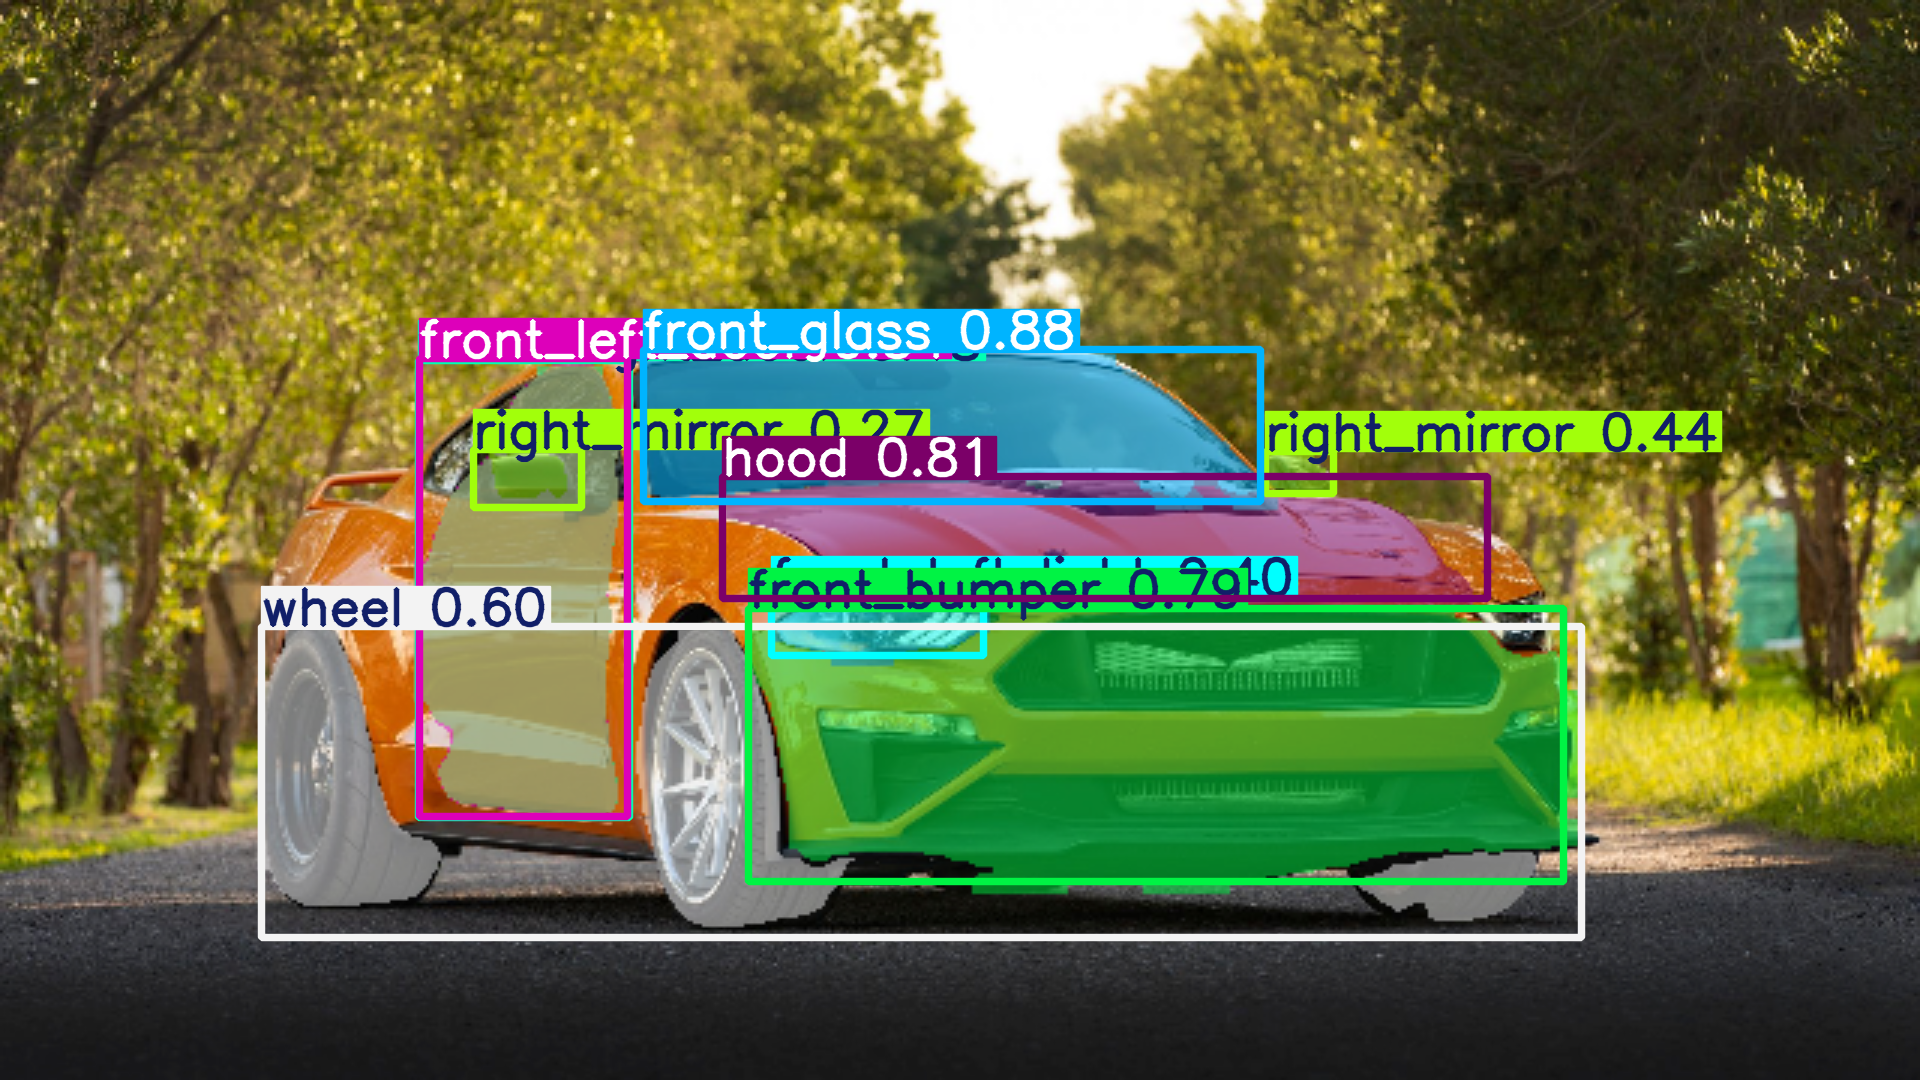

In [ ]:
# Process prediction results list
for result in prediction_results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    probs = result.probs  # Probs object for classification outputs
    result.show()  # display to screen
    result.save(filename = "result.jpg")  # save to disk

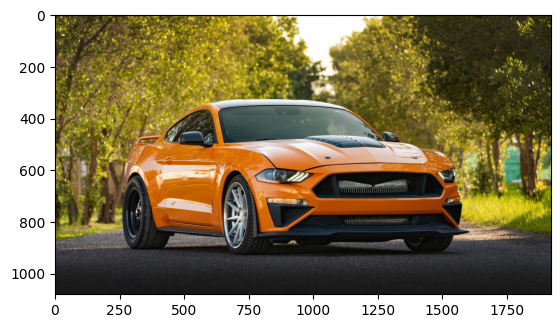

In [ ]:
# Get original image
image = prediction_results[0].orig_img
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

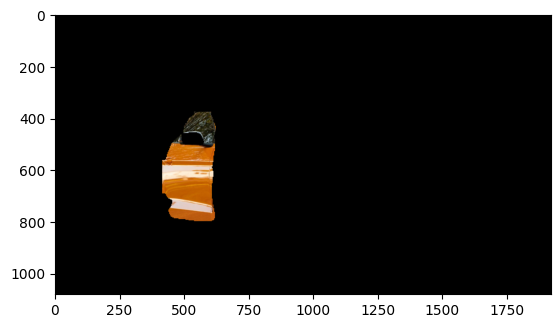

In [ ]:
image = prediction_results[0].orig_img
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask_image = masks.data[5].cpu().numpy()
mask_resized = cv2.resize(mask_image, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
mask_resized = mask_resized.astype(np.uint8)
masked_image = image * mask_resized[:, :, np.newaxis]
plt.imshow(masked_image)

In [ ]:
# For CV2 Format
# Load image
image = cv2.imread("carparts-image.jpg", cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get all boxes and crop as images
boxes = prediction_results[0].boxes.xyxy.cpu().numpy()

# Iterate through all detected parts
crops = []
for box in boxes:
    x1, y1, x2, y2 = map(int, box)
    crop = image[y1:y2, x1:x2]
    crops.append(crop)

array([[[206, 216, 225],
        [205, 215, 225],
        [204, 214, 224],
        ...,
        [134, 113,  46],
        [129, 108,  43],
        [125, 104,  39]],

       [[202, 211, 218],
        [201, 210, 219],
        [200, 209, 218],
        ...,
        [137, 114,  47],
        [133, 109,  45],
        [126, 105,  40]],

       [[197, 207, 217],
        [196, 206, 216],
        [195, 205, 215],
        ...,
        [134, 113,  48],
        [131, 110,  47],
        [126, 105,  42]],

       ...,

       [[227, 128,   8],
        [231, 130,  12],
        [232, 131,  13],
        ...,
        [107, 109,  96],
        [136, 136, 126],
        [187, 187, 179]],

       [[234, 137,  22],
        [238, 138,  24],
        [239, 139,  25],
        ...,
        [106, 108,  97],
        [107, 107,  97],
        [121, 121, 113]],

       [[236, 140,  30],
        [237, 141,  29],
        [239, 142,  29],
        ...,
        [104, 105,  99],
        [ 79,  79,  71],
        [104, 104,  96]]], dtype=uint8)
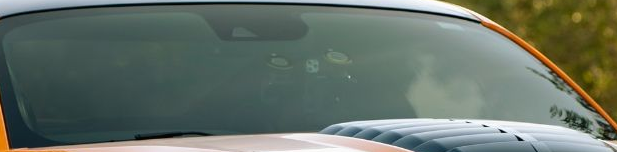

In [ ]:
# Visualize example of cropped image
crops[0]

In [ ]:
# For PIL Format
# Load image
image = Image.open("carparts-image.jpg")

# Get all boxes and crop as images
boxes = prediction_results[0].boxes.xyxy.cpu().numpy()

# Loop through detections
crops = []
for box in boxes:
    xmin, ymin, xmax, ymax = map(int, box)
    cropped = image.crop((xmin, ymin, xmax, ymax))
    crops.append(cropped)

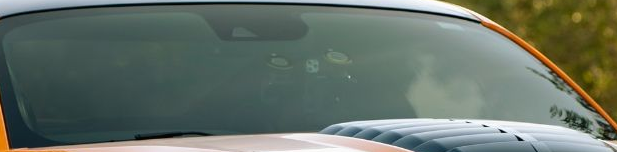

In [ ]:
crops[0]